In [9]:
import sys, os
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt

In [10]:
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PARENT_DIR)
conf = importlib.import_module('confs.double_int_conf')
env = getattr(conf, 'DoubleIntegratorEnv')(conf)


from neural_network import ActorCriticNet
from rl_trainer import RLTrainer
ac_net = ActorCriticNet(env, conf)
actor = ac_net.create_actor()
critic = ac_net.create_critic_sine()

# Load the weights
actor_path = '/home/seyoungree/Documents/GATO-RL/double_int/2025-07-08_11-22/actor_final.pth'
critic_path = '/home/seyoungree/Documents/GATO-RL/double_int/2025-07-08_11-22/critic_final.pth'
actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
actor.eval()
critic.eval()

Sequential(
  (0): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (1): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (2): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (3): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [11]:
%matplotlib inline

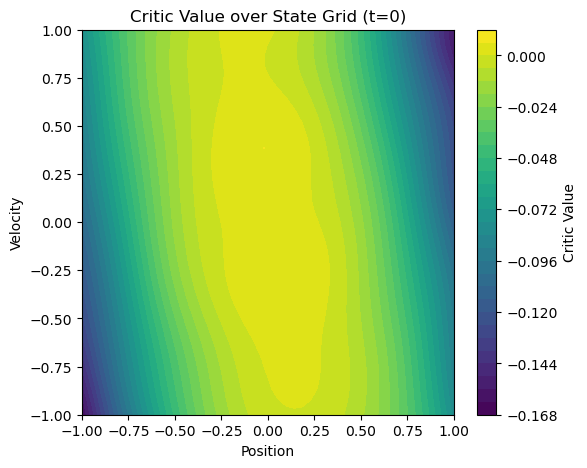

In [12]:
x = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)
X, V = np.meshgrid(x, v)
T = np.zeros_like(X)  # time = 0 for all

# Stack into state vectors: shape (N, 3)
states = np.stack([X.ravel(), V.ravel(), T.ravel()], axis=1)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Get critic values
with torch.no_grad():
    values = ac_net.eval(critic, states_tensor).cpu().numpy().reshape(X.shape)

# Plot
plt.figure(figsize=(6,5))
contour = plt.contourf(X, V, values, levels=30, cmap='viridis')
plt.colorbar(contour, label='Critic Value')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Critic Value over State Grid (t=0)')
plt.show()

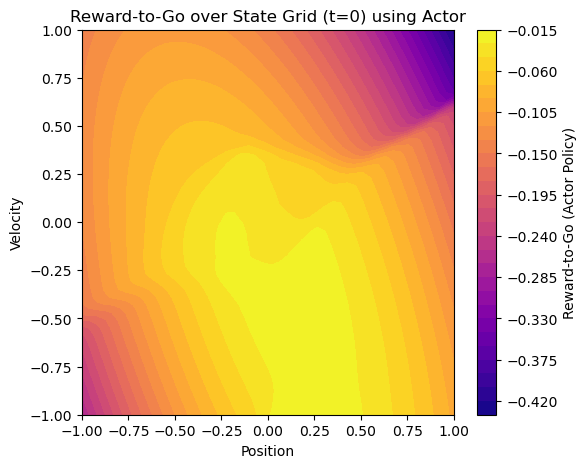

In [13]:
# Compute actual reward-to-go values using compute_partial_rtg for each grid state, with actor actions
rtg_values = np.zeros_like(X)
trainer = RLTrainer(env, None, conf, N_try=0)

for idx, (p, v) in enumerate(zip(X.ravel(), V.ravel())):
    init_state = np.array([p, v, 0.0])
    states = np.zeros((conf.NSTEPS + 1, conf.nx + 1))
    states[0] = init_state
    actions = np.zeros((conf.NSTEPS, conf.nu))
    for t in range(conf.NSTEPS):
        # Prepare state for actor (batch of 1)
        state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
        with torch.no_grad():
            action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
        actions[t] = action
        # Simulate next state
        states[t + 1] = env.simulate(states[t], actions[t])
        states[t + 1, :2] = 0
    _, rtg, _, _, _ = trainer.compute_partial_rtg(actions, states)
    rtg_values.ravel()[idx] = rtg[0]

# Plot the RTG values
plt.figure(figsize=(6,5))
contour = plt.contourf(X, V, rtg_values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Reward-to-Go (Actor Policy)')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Reward-to-Go over State Grid (t=0) using Actor')
plt.show()

Step 0: State=[1. 1. 0.], Action=5.0
Step 1: State=[1. 1. 0.], Action=5.0
Step 2: State=[1. 1. 0.], Action=5.0
Step 3: State=[1. 1. 0.], Action=5.0
Step 4: State=[1. 1. 0.], Action=5.0
Step 5: State=[1. 1. 0.], Action=5.0
Step 6: State=[1. 1. 0.], Action=5.0
Step 7: State=[1. 1. 0.], Action=5.0
Step 8: State=[1. 1. 0.], Action=5.0
Step 9: State=[1. 1. 0.], Action=5.0
Step 10: State=[1. 1. 0.], Action=5.0
Step 11: State=[1. 1. 0.], Action=5.0
Step 12: State=[1. 1. 0.], Action=5.0
Step 13: State=[1. 1. 0.], Action=5.0
Step 14: State=[1. 1. 0.], Action=5.0
Step 15: State=[1. 1. 0.], Action=5.0
Step 16: State=[1. 1. 0.], Action=5.0
Step 17: State=[1. 1. 0.], Action=5.0
Step 18: State=[1. 1. 0.], Action=5.0
Step 19: State=[1. 1. 0.], Action=5.0
Step 20: State=[1. 1. 0.], Action=5.0
Step 21: State=[1. 1. 0.], Action=5.0
Step 22: State=[1. 1. 0.], Action=5.0
Step 23: State=[1. 1. 0.], Action=5.0
Step 24: State=[1. 1. 0.], Action=5.0
Step 25: State=[1. 1. 0.], Action=5.0
Step 26: State=[1. 1. 

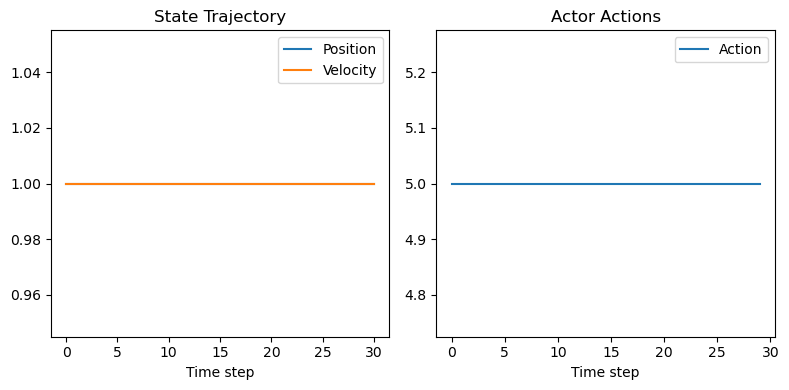

In [14]:
# Test the actor with a single trajectory rollout from an initial state

init_state = np.array([1.0, 1.0, 0.0])  # Example initial state: [position, velocity, time]
states = np.zeros((conf.NSTEPS + 1, conf.nx + 1))
states[0] = init_state
actions = np.zeros((conf.NSTEPS, conf.nu))

for t in range(conf.NSTEPS):
    state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
    with torch.no_grad():
        action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
    print(f"Step {t}: State={states[t]}, Action={action}")
    actions[t] = action
    states[t + 1] = env.simulate(states[t], actions[t])
    states[t + 1, :2] = np.clip(states[t + 1, :2], -1, 1)
    states[t + 1, 2] = 0.0

# Plot the trajectory
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[:,0], label='Position')
plt.plot(states[:,1], label='Velocity')
plt.xlabel('Time step')
plt.title('State Trajectory')
plt.legend()

plt.subplot(1,2,2)
plt.plot(actions, label='Action')
plt.xlabel('Time step')
plt.title('Actor Actions')
plt.legend()

plt.tight_layout()
plt.show()